In [1]:
%matplotlib inline
%load_ext autoreload

%autoreload 2
import os
import sys
import itertools
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from dnc.dnc import DNC
import dnc.utility as uf

# from feedforward_controller import FeedforwardController
from basic_recurrent_controller import BasicRecurrentController
from focus_recurrent_controller import FocusRecurrentController

from tqdm import tqdm
import time
import seaborn as sns
plt.rcParams['figure.figsize'] = (5, 10)

sess = None
# from tensorflow.examples.tutorials.mnist import input_data
# mnist = input_data.read_data_sets('/tmp/tensorflow/mnist/input_data', one_hot=True)

# TODO: For the DNC-controlled sliding window, just make the "sequence input" to the DNC be a sequence of images. Then
# make the first step of the controller to be to apply the index window on top of the image

In [2]:
def make_ims(kind, size=8, splits=4):
    if kind == "center":
        Input, _, Target_Output = uf.get_center_bar_images(bsize, size=size, splits=splits, stagger=False)
    elif kind == "right":
        Input, _, Target_Output = uf.get_right_bar_images(bsize, size=size, splits=splits, stagger=False)
    elif kind == "sd":
        Input,_, Target_Output = uf.get_sd_images(bsize, size=size, splits=splits,
        stagger=False, half_max_item=half_max_item)
    return Input, Target_Output

half_max_item = 3
bsize = 1

bsize = 10

input_side = 24
splits = 4
Input, Target_Output = make_ims("sd",input_side,splits)



dnc/utility.py:200: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  .5*size - half_item - offset:.5*size + half_item - offset] = bit_p1
dnc/utility.py:203: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  bit_p2*s_or_d


In [4]:
raw_focuses_row = np.load("/media/data_cifs/DNC_Visual_Reasoning_Results_Logs/raw_focuses_row_9199.npy")
raw_focuses_col = np.load("/media/data_cifs/DNC_Visual_Reasoning_Results_Logs/raw_focuses_col_9199.npy")
inputs = np.load("/media/data_cifs/DNC_Visual_Reasoning_Results_Logs/inputs_9199.npy")


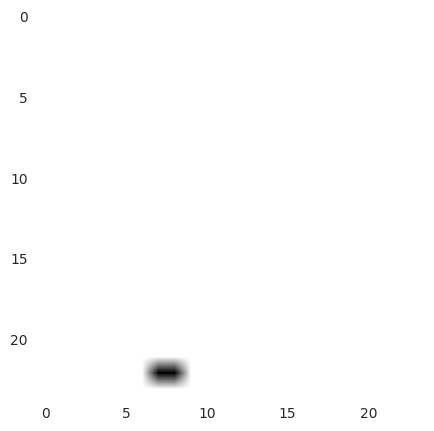

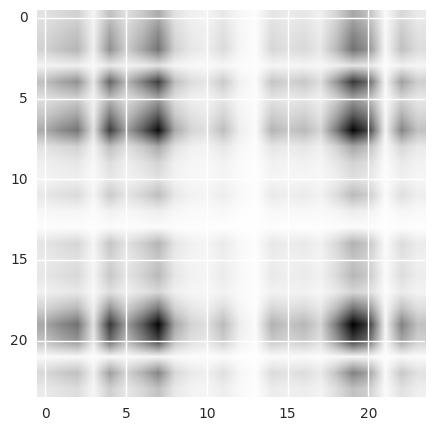

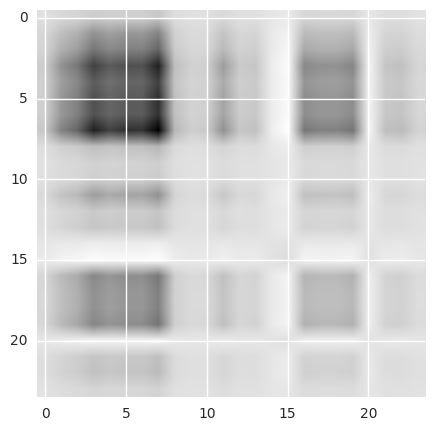

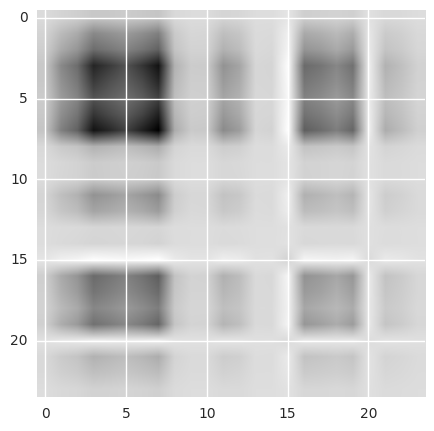

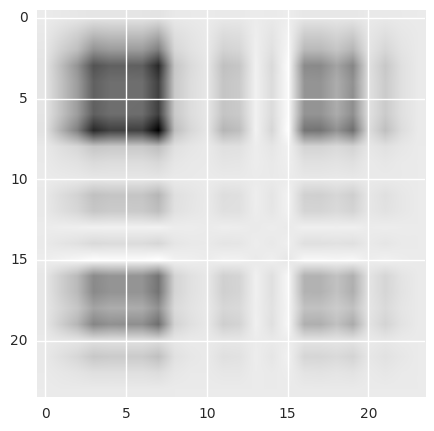

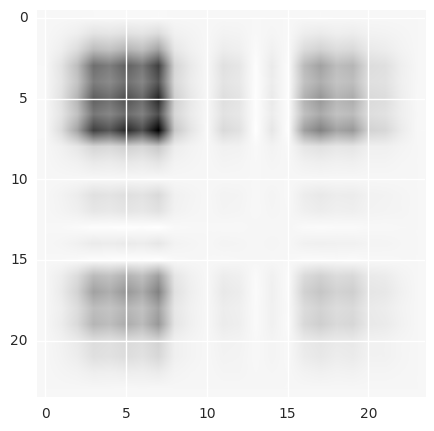

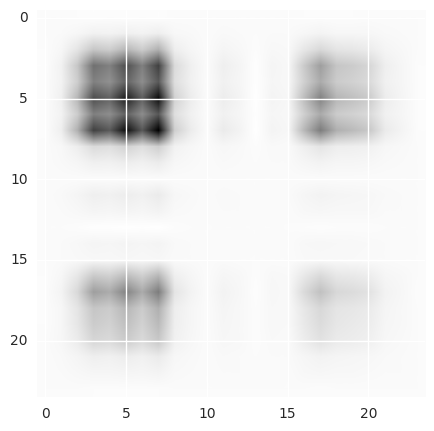

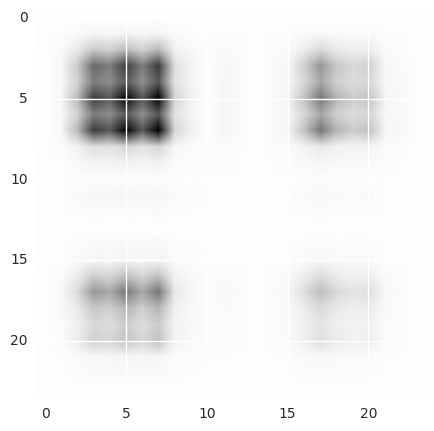

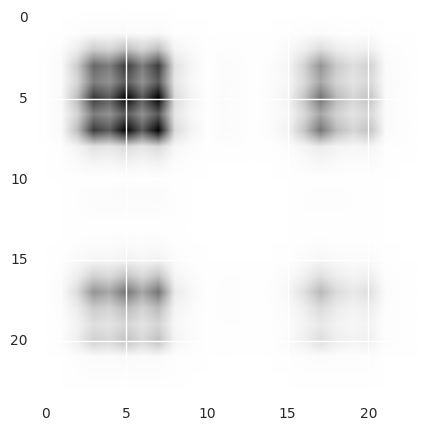

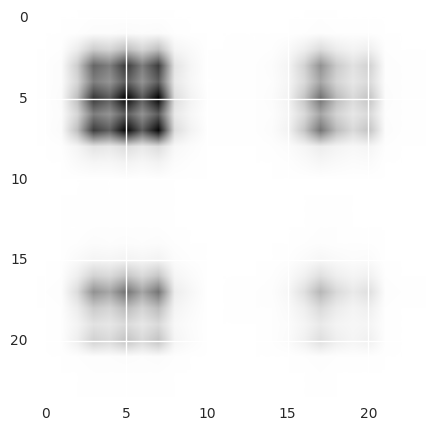

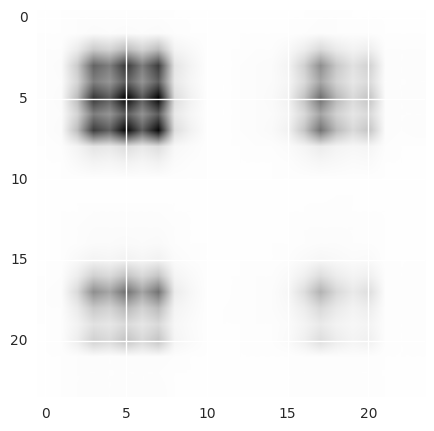

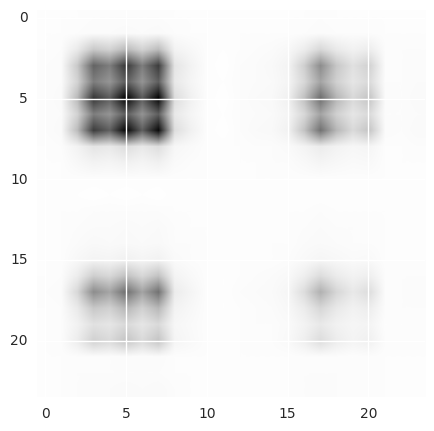

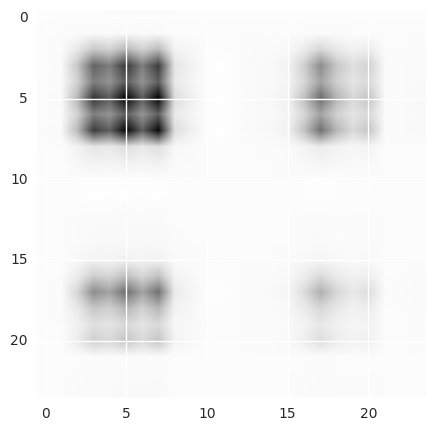

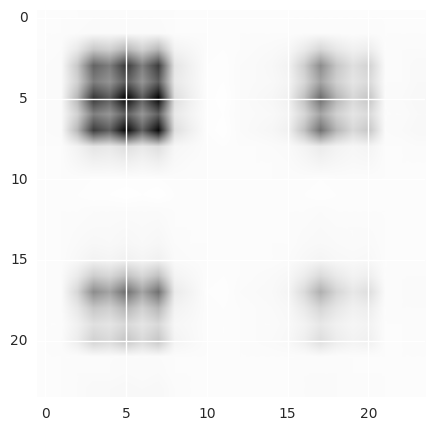

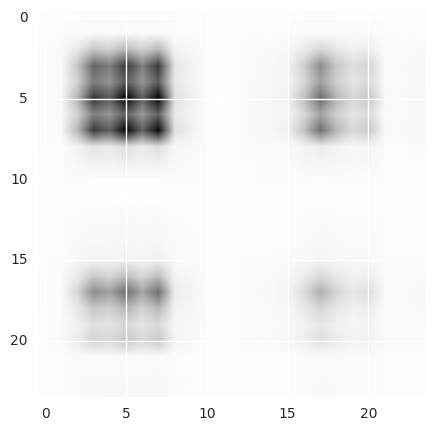

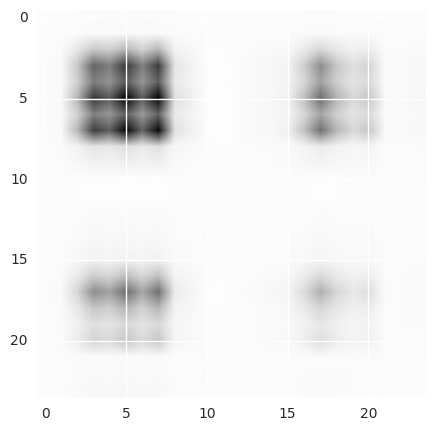

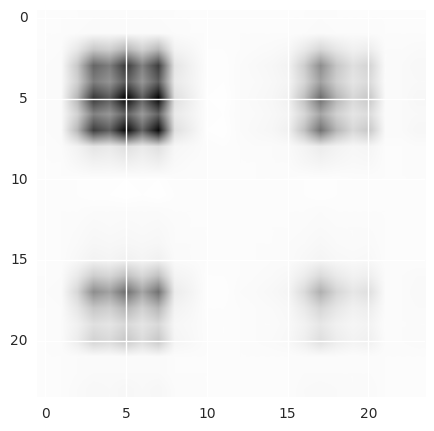

In [6]:
ind = 3
plt.figure()
plt.imshow(np.reshape(inputs[ind][0][0], (24,24)))
for i in range(16):
    plt.figure()
    plt.imshow(np.outer(raw_focuses_row[ind][i], raw_focuses_col[ind][i]))
    plt.show()
    
    
for i, w, r in zip(range(4), np.squeeze(v['write_weightings'][0]), np.squeeze(v['read_weightings'][0])):
    plt.subplot(4,4,i + 1)
    plt.title(i)
    plt.plot(w, label="w")
    plt.plot(r, label="r")
    plt.legend()

In [11]:
np.sqrt(576)

24.0

In [3]:
# num_labels = 2
def make_ims(kind, size=8, splits=4):
    if kind == "center":
        Input, _, Target_Output = uf.get_center_bar_images(bsize, size=size, splits=splits, stagger=False)
    elif kind == "right":
        Input, _, Target_Output = uf.get_right_bar_images(bsize, size=size, splits=splits, stagger=False)
    return Input, Target_Output


if not sess is None:
    sess.close()

bsize = 1
input_size = 64
num_labels = 2
sequence_length = 16
tf.reset_default_graph()
sess = tf.InteractiveSession(config=tf.ConfigProto(allow_soft_placement=True))

ncomputer = DNC(
    FocusRecurrentController,
    input_size=input_size,
    output_size=num_labels,
    max_sequence_length=sequence_length,
    memory_words_num=10,
    memory_word_size=10,
    memory_read_heads=1,
    batch_size=bsize
)
assert ncomputer.controller.has_recurrent_nn

raw_outputs, memory_views = ncomputer.get_outputs()
output = tf.argmax(raw_outputs[:, sequence_length - 1, :], 1)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(raw_outputs[:, sequence_length - 1, :], 
                                                              ncomputer.target_output_final))

start = time.time()
updt = uf.get_updt(loss)
print time.time() - start

init = tf.global_variables_initializer()
print "initializing..."
sess.run(init)
print "initialized!"


/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return umr_minimum(a, axis, None, out, keepdims)
100%|██████████| 16/16 [00:16<00:00,  1.01it/s]


computing gradients...


  0%|          | 0/19 [00:00<?, ?it/s]100%|██████████| 19/19 [00:00<00:00, 264.24it/s]


applying gradients...
45.584788084
initializing...
initialized!


In [4]:

print_step = 200
losses = []
inputs = []
outputs = []
targets = []
views = []
raw_focuses_row = []
raw_focuses_col = []
focuses = []

for i in tqdm(range(1000000)):
    
    Input, Target_Output = make_ims("right")

    OUT = sess.run([
        loss,
        output,
        memory_views,
        updt] + 
        ncomputer.controller.focus_row +
        ncomputer.controller.focus_col
        , feed_dict={
        ncomputer.input_data: Input,
        ncomputer.target_output_final: Target_Output,
        ncomputer.sequence_length: sequence_length
    })
    l, o, v = OUT[:3]
    fr = OUT[4:4+len(ncomputer.controller.focus_row)]
    fc = OUT[4+len(ncomputer.controller.focus_row):]
    pairs = zip(np.argmax(np.array(fr)[:,0,:], -1), np.argmax(np.array(fr)[:,0,:], -1))

    losses.append(l)
    inputs.append(Input)
    outputs += list(o)
    views.append(v)
    targets += list(np.argmax(Target_Output, axis=-1))
    raw_focuses_row.append(np.array(fc)[:,0,:])
    raw_focuses_col.append(np.array(fc)[:,0,:])
    focuses.append(pairs)
    if len(targets) % print_step == 0 and len(targets) > 0:
        print "loss", np.mean(losses[-print_step:])
        print "matches", np.mean(np.array(targets[-print_step:]) == np.array(outputs[-print_step:]))


  0%|          | 0/1000000 [00:00<?, ?it/s]dnc/utility.py:147: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
  label[pos] = 1
  0%|          | 200/1000000 [00:58<71:02:26,  3.91it/s] 

loss 0.693091
matches 0.52


  0%|          | 219/1000000 [01:03<56:35:25,  4.91it/s]   0%|          | 202/1000000 [00:59<99:31:39,  2.79it/s] 

KeyboardInterrupt: 

In [6]:
focuses[-1]

[(2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3)]

In [25]:
# rup

array([[-0.00196703,  0.00065425, -0.00131982, -0.00144165]], dtype=float32)

In [ ]:
# plt.subplot(2,2,1)
# plt.imshow(np.reshape(Input[0][0], (4,4)))
# plt.subplot(2,2,2)
# plt.imshow(np.reshape(Input[0][1], (4,4)))
# plt.subplot(2,2,3)
# plt.imshow(np.reshape(Input[0][2], (4,4)))
# plt.subplot(2,2,4)
# plt.imshow(np.reshape(Input[0][3], (4,4)))

In [ ]:
# focus_row_updater, focus_col_updater, normed_nn_output, rup = sess.run([
#         ncomputer.controller.focus_row_updater,
#         ncomputer.controller.focus_col_updater,
#         ncomputer.controller.nn_output/(1e-4 + tf.reduce_sum(tf.abs(ncomputer.controller.nn_output))), 
#         tf.matmul(ncomputer.controller.nn_output/(1e-4 + tf.reduce_sum(tf.abs(ncomputer.controller.nn_output))), 
#                   ncomputer.controller.focus_row_updater)
        
#     ], feed_dict={
#         ncomputer.input_data: Input,
#         ncomputer.target_output_final: Target_Output,
#         ncomputer.sequence_length: sequence_length
#     })

In [ ]:
# ix = 4
# v = views[ix]
# print targets[ix]
# Input = inputs[ix]

# for i, w, r in zip(range(4), np.squeeze(v['write_weightings'][0]), np.squeeze(v['read_weightings'][0])):
#     plt.subplot(2,2,i + 1)
#     plt.plot(w, label="w")
#     plt.plot(r, label="r")
#     plt.legend()

In [20]:
# # batch_x, batch_y = mnist.train.next_batch(bsize)
# # Input, Target_Output = get_im_sequence(batch_x, batch_y)
# Input, _, Target_Output = make_ims(bsize, size=im_size, splits=im_splits)

# l, o, v, _ = sess.run([
#     loss,
#     output,
#     memory_views, 
#     updt
# ], feed_dict={
#     ncomputer.input_data: Input,
#     ncomputer.target_output_final: Target_Output,
#     ncomputer.sequence_length: sequence_length
# })
# o

array([1])

In [32]:

# with tf.variable_scope("testing4"): 
#     Xf2 = tf.placeholder(tf.float32, [1, 26], name="Xf2")
#     state2 = tf.placeholder(tf.float32, [1, 256], name="state2")
#     out = ncomputer.controller.run_controller_network(Xf2, state2)
#     init = tf.global_variables_initializer()
#     print "initializing..."
#     sess.run(init)
#     print "initialized!"
#     l1_output, l2_output, l3_output, nn_output = sess.run([
#             ncomputer.controller.l1_output,
#             ncomputer.controller.l2_output,
#             ncomputer.controller.l3_output, 
#             ncomputer.controller.nn_output
#         ], feed_dict={
#             Xf2: np.zeros((1, 26)),
#             state2: np.random.random((1, 256))
#         })

initializing...
initialized!


In [6]:
# ncomputer.save(sess, "ckpts", "basic_recurrent_controller_get_lrb_images_task.ckpt")

In [ ]:

#TODO: VISUALIZE GRADIENTS AND MEMORY

















In [34]:
# print Target_Output
# plt.subplot(2,2,1)
# plt.imshow(np.reshape(Input[0][0], (4,4)))
# plt.subplot(2,2,2)
# plt.imshow(np.reshape(Input[0][1], (4,4)))
# plt.subplot(2,2,3)
# plt.imshow(np.reshape(Input[0][2], (4,4)))
# plt.subplot(2,2,4)
# plt.imshow(np.reshape(Input[0][3], (4,4)))